<a href="https://colab.research.google.com/github/panicia16/Data-Analysis/blob/main/User_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Impor packages

In [1]:
# pip install pandas
# pip install numpy
# pip install datetime
import pandas as pd
import numpy as np
import datetime as dt

In [2]:
import os
os.getcwd()

'/content'

# Impor data dari CSV ke DataFrame

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/MySkill/Online Retail Data.csv', header=0)
df

,order_id,product_code,product_name,quantity,order_date,price,customer_id
0,493410,TEST001,This is a test product.,5,2010-01-04 09:24:00,4.50,12346.0
1,C493411,21539,RETRO SPOTS BUTTER DISH,-1,2010-01-04 09:43:00,4.25,14590.0
2,493412,TEST001,This is a test product.,5,2010-01-04 09:53:00,4.50,12346.0
3,493413,21724,PANDA AND BUNNIES STICKER SHEET,1,2010-01-04 09:54:00,0.85,NaN
4,493413,84578,ELEPHANT TOY WITH BLUE T-SHIRT,1,2010-01-04 09:54:00,3.75,NaN
...,...,...,...,...,...,...,...
461768,539991,21618,4 WILDFLOWER BOTANICAL CANDLES,1,2010-12-23 16:49:00,1.25,NaN
461769,539991,72741,GRAND CHOCOLATECANDLE,4,2010-12-23 16:49:00,1.45,NaN
461770,539992,21470,FLOWER VINE RAFFIA FOOD COVER,1,2010-12-23 17:41:00,3.75,NaN
461771,539992,22258,FELT FARM ANIMAL RABBIT,1,2010-12-23 17:41:00,1.25,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 461773 entries, 0 to 461772
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   order_id      461773 non-null  object 
 1   product_code  461773 non-null  object 
 2   product_name  459055 non-null  object 
 3   quantity      461773 non-null  int64  
 4   order_date    461773 non-null  object 
 5   price         461773 non-null  float64
 6   customer_id   360853 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 24.7+ MB


# Data cleansing

In [6]:
df_clean = df.copy()
# membuat kolom date
df_clean['date'] = pd.to_datetime(df_clean['order_date']).dt.date.astype('datetime64[ns]')
# menghapus semua baris tanpa customer_id
df_clean = df_clean[~df_clean['customer_id'].isna()]
# menghapus semua baris tanpa product_name
df_clean = df_clean[~df_clean['product_name'].isna()]
# membuat semua product_name berhuruf kecil
df_clean['product_name'] = df_clean['product_name'].str.lower()
# menghapus semua baris dengan product_code atau product_name test
df_clean = df_clean[(~df_clean['product_code'].str.lower().str.contains('test')) |
                    (~df_clean['product_name'].str.contains('test '))]
# membuat kolom order_status dengan nilai 'cancelled' jika order_id diawali dengan huruf 'c' dan 'delivered' jika order_id tanpa awalan huruf 'c'
df_clean['order_status'] = np.where(df_clean['order_id'].str[:1]=='C', 'cancelled', 'delivered')
# mengubah nilai quantity yang negatif menjadi positif karena nilai negatif tersebut hanya menandakan order tersebut cancelled
df_clean['quantity'] = df_clean['quantity'].abs()
# menghapus baris dengan price bernilai negatif
df_clean = df_clean[df_clean['price']>0]
# membuat nilai amount, yaitu perkalian antara quantity dan price
df_clean['amount'] = df_clean['quantity'] * df_clean['price']
# mengganti product_name dari product_code yang memiliki beberapa product_name dengan salah satu product_name-nya yang paling sering muncul
most_freq_product_name = df_clean.groupby(['product_code','product_name'], as_index=False).agg(order_cnt=('order_id','nunique')).sort_values(['product_code','order_cnt'], ascending=[True,False])
most_freq_product_name['rank'] = most_freq_product_name.groupby('product_code')['order_cnt'].rank(method='first', ascending=False)
most_freq_product_name = most_freq_product_name[most_freq_product_name['rank']==1].drop(columns=['order_cnt','rank'])
df_clean = df_clean.merge(most_freq_product_name.rename(columns={'product_name':'most_freq_product_name'}), how='left', on='product_code')
df_clean['product_name'] = df_clean['most_freq_product_name']
df_clean = df_clean.drop(columns='most_freq_product_name')
# mengkonversi customer_id menjadi string
df_clean['customer_id'] = df_clean['customer_id'].astype(str)
# menghapus outlier
from scipy import stats
df_clean = df_clean[(np.abs(stats.zscore(df_clean[['quantity','amount']]))<3).all(axis=1)]
df_clean = df_clean.reset_index(drop=True)
df_clean

,order_id,product_code,product_name,quantity,order_date,price,customer_id,date,order_status,amount
0,C493411,21539,red retrospot butter dish,1,2010-01-04 09:43:00,4.25,14590.0,2010-01-04,cancelled,4.25
1,493414,21844,red retrospot mug,36,2010-01-04 10:28:00,2.55,14590.0,2010-01-04,delivered,91.80
2,493414,21533,retro spot large milk jug,12,2010-01-04 10:28:00,4.25,14590.0,2010-01-04,delivered,51.00
3,493414,37508,new england ceramic cake server,2,2010-01-04 10:28:00,2.55,14590.0,2010-01-04,delivered,5.10
4,493414,35001G,hand open shape gold,2,2010-01-04 10:28:00,4.25,14590.0,2010-01-04,delivered,8.50
...,...,...,...,...,...,...,...,...,...,...
358464,539988,84380,set of 3 butterfly cookie cutters,1,2010-12-23 16:06:00,1.25,18116.0,2010-12-23,delivered,1.25
358465,539988,84849D,hot baths soap holder,1,2010-12-23 16:06:00,1.69,18116.0,2010-12-23,delivered,1.69
358466,539988,84849B,fairy soap soap holder,1,2010-12-23 16:06:00,1.69,18116.0,2010-12-23,delivered,1.69
358467,539988,22854,cream sweetheart egg holder,2,2010-12-23 16:06:00,4.95,18116.0,2010-12-23,delivered,9.90


In [7]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358469 entries, 0 to 358468
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   order_id      358469 non-null  object        
 1   product_code  358469 non-null  object        
 2   product_name  358469 non-null  object        
 3   quantity      358469 non-null  int64         
 4   order_date    358469 non-null  object        
 5   price         358469 non-null  float64       
 6   customer_id   358469 non-null  object        
 7   date          358469 non-null  datetime64[ns]
 8   order_status  358469 non-null  object        
 9   amount        358469 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(6)
memory usage: 27.3+ MB


# Membuat RFM segmentation

## Agregat data transaksi ke bentuk summary total transaksi (order), total nilai order (order value), tanggal order terakhir dari setiap pengguna

In [8]:
df_user = df_clean.groupby('customer_id', as_index=False).agg(order_cnt=('order_id','nunique'),max_order_date=('date','max'),total_order_value=('amount','sum'))
df_user

,customer_id,order_cnt,max_order_date,total_order_value
0,12346.0,5,2010-10-04,602.40
1,12608.0,1,2010-10-31,415.79
2,12745.0,2,2010-08-10,723.85
3,12746.0,2,2010-06-30,266.35
4,12747.0,19,2010-12-13,4094.79
...,...,...,...,...
3884,18283.0,6,2010-11-22,641.77
3885,18284.0,2,2010-10-06,486.68
3886,18285.0,1,2010-02-17,427.00
3887,18286.0,2,2010-08-20,941.48


## Buat kolom jumlah hari sejak order terakhir

In [9]:
today = df_clean['date'].max()
df_user['day_since_last_order'] = (today - df_user['max_order_date']).dt.days
df_user

,customer_id,order_cnt,max_order_date,total_order_value,day_since_last_order
0,12346.0,5,2010-10-04,602.40,80
1,12608.0,1,2010-10-31,415.79,53
2,12745.0,2,2010-08-10,723.85,135
3,12746.0,2,2010-06-30,266.35,176
4,12747.0,19,2010-12-13,4094.79,10
...,...,...,...,...,...
3884,18283.0,6,2010-11-22,641.77,31
3885,18284.0,2,2010-10-06,486.68,78
3886,18285.0,1,2010-02-17,427.00,309
3887,18286.0,2,2010-08-20,941.48,125


In [10]:
df_user.describe()

,order_cnt,max_order_date,total_order_value,day_since_last_order
count,3889.000000,3889,3889.000000,3889.000000
mean,5.128568,2010-09-23 04:46:57.793777664,1544.623084,90.800720
min,1.000000,2010-01-05 00:00:00,1.250000,0.000000
25%,1.000000,2010-08-19 00:00:00,296.360000,25.000000
50%,3.000000,2010-10-26 00:00:00,648.200000,58.000000
75%,6.000000,2010-11-28 00:00:00,1585.940000,126.000000
max,163.000000,2010-12-23 00:00:00,71970.390000,352.000000
std,8.499330,NaN,3434.816315,88.873286


## Buat binning dari jumlah hari sejak order terakhir yang terdiri dari 5 bins dengan batas-batasnya merupakan min, P20, P40, P60, P80, max dan beri label 1 sampai 5 dari bin tertinggi ke terendah sebagai skor recency

In [11]:
df_user['recency_score'] = pd.cut(df_user['day_since_last_order'],
                                  bins=[df_user['day_since_last_order'].min(),
                                        np.percentile(df_user['day_since_last_order'], 20),
                                        np.percentile(df_user['day_since_last_order'], 40),
                                        np.percentile(df_user['day_since_last_order'], 60),
                                        np.percentile(df_user['day_since_last_order'], 80),
                                        df_user['day_since_last_order'].max()],
                                  labels=[5, 4, 3, 2, 1],
                                  include_lowest=True).astype(int)
df_user

,customer_id,order_cnt,max_order_date,total_order_value,day_since_last_order,recency_score
0,12346.0,5,2010-10-04,602.40,80,2
1,12608.0,1,2010-10-31,415.79,53,3
2,12745.0,2,2010-08-10,723.85,135,2
3,12746.0,2,2010-06-30,266.35,176,1
4,12747.0,19,2010-12-13,4094.79,10,5
...,...,...,...,...,...,...
3884,18283.0,6,2010-11-22,641.77,31,4
3885,18284.0,2,2010-10-06,486.68,78,2
3886,18285.0,1,2010-02-17,427.00,309,1
3887,18286.0,2,2010-08-20,941.48,125,2


In [12]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3889 entries, 0 to 3888
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   customer_id           3889 non-null   object        
 1   order_cnt             3889 non-null   int64         
 2   max_order_date        3889 non-null   datetime64[ns]
 3   total_order_value     3889 non-null   float64       
 4   day_since_last_order  3889 non-null   int64         
 5   recency_score         3889 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 182.4+ KB


## Buat binning dari total transaksi (order) yang terdiri dari 5 bins dengan batas-batasnya merupakan min, P20, P40, P60, P80, max dan beri label 1 sampai 5 dari bin terendah ke tertinggi sebagai skor frequency

In [13]:
df_user['frequency_score'] = pd.cut(df_user['order_cnt'],
                                    bins=[0,
                                          np.percentile(df_user['order_cnt'], 20),
                                          np.percentile(df_user['order_cnt'], 40),
                                          np.percentile(df_user['order_cnt'], 60),
                                          np.percentile(df_user['order_cnt'], 80),
                                          df_user['order_cnt'].max()],
                                    labels=[1, 2, 3, 4, 5],
                                    include_lowest=True).astype(int)
df_user

,customer_id,order_cnt,max_order_date,total_order_value,day_since_last_order,recency_score,frequency_score
0,12346.0,5,2010-10-04,602.40,80,2,4
1,12608.0,1,2010-10-31,415.79,53,3,1
2,12745.0,2,2010-08-10,723.85,135,2,2
3,12746.0,2,2010-06-30,266.35,176,1,2
4,12747.0,19,2010-12-13,4094.79,10,5,5
...,...,...,...,...,...,...,...
3884,18283.0,6,2010-11-22,641.77,31,4,4
3885,18284.0,2,2010-10-06,486.68,78,2,2
3886,18285.0,1,2010-02-17,427.00,309,1,1
3887,18286.0,2,2010-08-20,941.48,125,2,2


In [15]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3889 entries, 0 to 3888
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   customer_id           3889 non-null   object        
 1   order_cnt             3889 non-null   int64         
 2   max_order_date        3889 non-null   datetime64[ns]
 3   total_order_value     3889 non-null   float64       
 4   day_since_last_order  3889 non-null   int64         
 5   recency_score         3889 non-null   int64         
 6   frequency_score       3889 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 212.8+ KB


## Buat binning dari total nilai order (order value) yang terdiri dari 5 bins dengan batas-batasnya merupakan min, P20, P40, P60, P80, max dan beri label 1 sampai 5 dari bin terendah ke tertinggi sebagai skor monetary

In [16]:
df_user['monetary_score'] = pd.cut(df_user['total_order_value'],
                                   bins=[df_user['total_order_value'].min(),
                                         np.percentile(df_user['total_order_value'], 20),
                                         np.percentile(df_user['total_order_value'], 40),
                                         np.percentile(df_user['total_order_value'], 60),
                                         np.percentile(df_user['total_order_value'], 80),
                                         df_user['total_order_value'].max()],
                                   labels=[1, 2, 3, 4, 5],
                                   include_lowest=True).astype(int)
df_user

,customer_id,order_cnt,max_order_date,total_order_value,day_since_last_order,recency_score,frequency_score,monetary_score
0,12346.0,5,2010-10-04,602.40,80,2,4,3
1,12608.0,1,2010-10-31,415.79,53,3,1,2
2,12745.0,2,2010-08-10,723.85,135,2,2,3
3,12746.0,2,2010-06-30,266.35,176,1,2,2
4,12747.0,19,2010-12-13,4094.79,10,5,5,5
...,...,...,...,...,...,...,...,...
3884,18283.0,6,2010-11-22,641.77,31,4,4,3
3885,18284.0,2,2010-10-06,486.68,78,2,2,3
3886,18285.0,1,2010-02-17,427.00,309,1,1,2
3887,18286.0,2,2010-08-20,941.48,125,2,2,4


In [17]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3889 entries, 0 to 3888
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   customer_id           3889 non-null   object        
 1   order_cnt             3889 non-null   int64         
 2   max_order_date        3889 non-null   datetime64[ns]
 3   total_order_value     3889 non-null   float64       
 4   day_since_last_order  3889 non-null   int64         
 5   recency_score         3889 non-null   int64         
 6   frequency_score       3889 non-null   int64         
 7   monetary_score        3889 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(5), object(1)
memory usage: 243.2+ KB


## Buat kolom nama segmen berdasarkan skor recency dan frequency

In [18]:
df_user['segment'] = np.select(
    [(df_user['recency_score']==5) & (df_user['frequency_score']>=4),
     (df_user['recency_score'].between(3, 4)) & (df_user['frequency_score']>=4),
     (df_user['recency_score']>=4) & (df_user['frequency_score'].between(2, 3)),
     (df_user['recency_score']<=2) & (df_user['frequency_score']==5),
     (df_user['recency_score']==3) & (df_user['frequency_score']==3),
     (df_user['recency_score']==5) & (df_user['frequency_score']==1),
     (df_user['recency_score']==4) & (df_user['frequency_score']==1),
     (df_user['recency_score']<=2) & (df_user['frequency_score'].between(3, 4)),
     (df_user['recency_score']==3) & (df_user['frequency_score']<=2),
     (df_user['recency_score']<=2) & (df_user['frequency_score']<=2)],
    ['01-Champion', '02-Loyal Customers', '03-Potential Loyalists', "04-Can't Lose Them", '05-Need Attention',
     '06-New Customers', '07-Promising', '08-At Risk', '09-About to Sleep', '10-Hibernating'],
    default=''
)
df_user

,customer_id,order_cnt,max_order_date,total_order_value,day_since_last_order,recency_score,frequency_score,monetary_score,segment
0,12346.0,5,2010-10-04,602.40,80,2,4,3,08-At Risk
1,12608.0,1,2010-10-31,415.79,53,3,1,2,09-About to Sleep
2,12745.0,2,2010-08-10,723.85,135,2,2,3,10-Hibernating
3,12746.0,2,2010-06-30,266.35,176,1,2,2,10-Hibernating
4,12747.0,19,2010-12-13,4094.79,10,5,5,5,01-Champion
...,...,...,...,...,...,...,...,...,...
3884,18283.0,6,2010-11-22,641.77,31,4,4,3,02-Loyal Customers
3885,18284.0,2,2010-10-06,486.68,78,2,2,3,10-Hibernating
3886,18285.0,1,2010-02-17,427.00,309,1,1,2,10-Hibernating
3887,18286.0,2,2010-08-20,941.48,125,2,2,4,10-Hibernating


In [19]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3889 entries, 0 to 3888
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   customer_id           3889 non-null   object        
 1   order_cnt             3889 non-null   int64         
 2   max_order_date        3889 non-null   datetime64[ns]
 3   total_order_value     3889 non-null   float64       
 4   day_since_last_order  3889 non-null   int64         
 5   recency_score         3889 non-null   int64         
 6   frequency_score       3889 non-null   int64         
 7   monetary_score        3889 non-null   int64         
 8   segment               3889 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(5), object(2)
memory usage: 273.6+ KB


## Tampilkan summary dari RFM segmentation (poin 8) berupa banyaknya pengguna, rata-rata dan median dari total order, total order value, dan jumlah hari sejak order terakhir

In [20]:
summary = pd.pivot_table(df_user, index='segment',
               values=['customer_id','day_since_last_order','order_cnt','total_order_value'],
               aggfunc={'customer_id': pd.Series.nunique,
                        'day_since_last_order': [np.mean, np.median],
                        'order_cnt': [np.mean, np.median],
                        'total_order_value': [np.mean, np.median]})
summary['pct_unique'] = (summary['customer_id'] / summary['customer_id'].sum() * 100).round(1)
summary

/tmp/ipython-input-690746973.py:1: FutureWarning: The provided callable <function mean at 0x7a3499370220> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  summary = pd.pivot_table(df_user, index='segment',
/tmp/ipython-input-690746973.py:1: FutureWarning: The provided callable <function median at 0x7a34967c4540> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  summary = pd.pivot_table(df_user, index='segment',


customer_id day_since_last_order         order_cnt  \
                           nunique                 mean median       mean   
segment                                                                     
01-Champion                    550            10.618182    9.5  15.467273   
02-Loyal Customers             546            40.864469   37.0   8.767399   
03-Potential Loyalists         523            23.573614   24.0   2.829828   
04-Can't Lose Them              64           121.984375  112.5  11.375000   
05-Need Attention              176            58.613636   59.0   3.397727   
06-New Customers                50            14.220000   16.0   1.000000   
07-Promising                   142            32.760563   34.0   1.000000   
08-At Risk                     426           140.455399  120.0   4.136150   
09-About to Sleep              352            58.735795   58.0   1.417614   
10-Hibernating                1060           196.837736  199.0   1.313208   

                              total_order_value           pct_unique  
                       median              mean    median             
segment                                                               
01-Champion              10.0       5003.674245  2775.525       14.1  
02-Loyal Customers        7.0       2622.817826  1946.850       14.0  
03-Potential Loyalists    3.0        766.769828   622.070       13.4  
04-Can't Lose Them        9.5       2839.948125  2268.405        1.6  
05-Need Attention         3.0        989.232676   826.370        4.5  
06-New Customers          1.0        244.689000   193.675        1.3  
07-Promising              1.0        287.800282   238.440        3.7  
08-At Risk                4.0       1153.825683   875.430       11.0  
09-About to Sleep         1.0        448.229688   334.755        9.1  
10-Hibernating            1.0        343.083842   257.005       27.3

## Visualisasi RFM Segmentation Summary

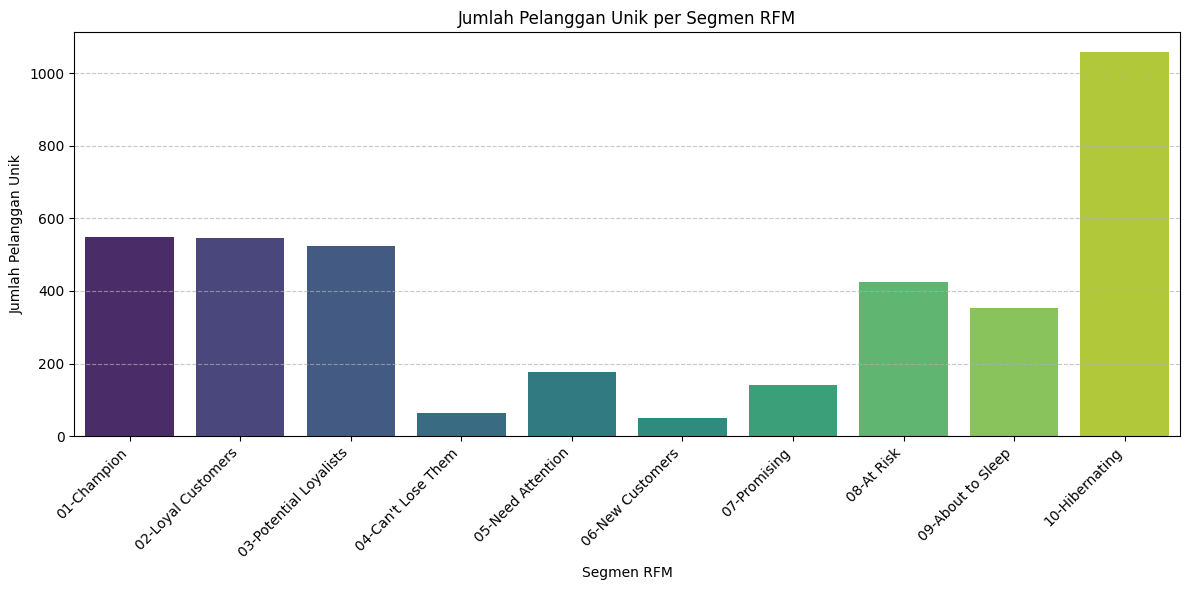

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

summary_plot = summary.reset_index()

# Bar chart untuk jumlah pelanggan unik per Segmen RFM
plt.figure(figsize=(12, 6))
sns.barplot(x='segment', y=('customer_id', 'nunique'), data=summary_plot, palette='viridis', hue='segment', legend=False)
plt.title('Jumlah Pelanggan Unik per Segmen RFM')
plt.xlabel('Segmen RFM')
plt.ylabel('Jumlah Pelanggan Unik')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Insight

Berdasarkan segmentasi pengguna (RFM Cohort Analysis), ditemukan bahwa fokus program pemasaran dan retensi harus disesuaikan dengan tiga segmen terbesar dan segmen yang memiliki potensi peningkatan nilai tertinggi.

Tiga segmen terbesar mendominasi total basis pengguna:

* Hibernating (1060 pengguna / 27.3%) yaitu Segmen terbesar, menunjukkan kurang akitfnya pengguna dalam bertransaksi. Dapat melakukan program khusus dengan fokus peningkatan urgensi bertransaksi sehingga dapat naik ke segmen champion.
* Champion (550 pengguna / 14.1%) yaitu Segmen dengan nilai tertinggi dan frekuensi transaksi terbaik.
* Loyal Customers (546 pengguna / 14.0%) yaitu Segmen loyal yang perlu didorong untuk mempertahankan status dan naik ke Champion.
